In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Завантаження необхідних датасетів

In [ ]:
# тренувальний сет
train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv') 
# тестовий сет
test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
# сет із описом колонок
description = pd.read_csv('/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv', encoding='latin1')

# Перший погляд на дані

In [ ]:
train.head()

In [ ]:
train.sample(10)

In [ ]:
test.head()

In [ ]:
test.sample(10)

In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
train[train.duplicated()]

In [ ]:
test[test.duplicated()]

Отже, датасети не містять дублікатів.

In [ ]:
set(train.columns) - set(test.columns)

Можемо спостерігати, що в тренувальному сеті є на одну колонку більше, тобто тестовий сет не має колонку 'TARGET'. Поглянемо на опис колонки.

In [ ]:
description.head()

Створимо функцію, яка буде повертати опис за назвою колонки для подальшого використання.

In [ ]:
def descr(col_name: str):
    descr_table = description[description['Table'] == 'application_{train|test}.csv']
    return str(descr_table[descr_table['Row'] == col_name][['Description']].values[0][0])

In [ ]:
descr('TARGET')

Колонка 'TARGET' вказує на наявність проблем з оплатою користувачів. Отже ми можемо використати дану колонку для перевірки кореляції інших фіч.
    
    
Також з опису колонок можна зробити висновок, що колонка 'SK_ID_CURR' може бути виключена.

In [ ]:
# train = train.drop('SK_ID_CURR', axis=1)
# test = test.drop('SK_ID_CURR', axis=1)

# Типи фіч

In [ ]:
set(train.dtypes)

In [ ]:
categorical_feachers_train = train.select_dtypes(include=['object']).columns
categorical_feachers_test = test.select_dtypes(include=['object']).columns
all(categorical_feachers_train == categorical_feachers_test)

In [ ]:
numerical_feachers_train = train.drop('TARGET', axis=1).select_dtypes(include=['int64', 'float64']).columns
numerical_feachers_test = test.select_dtypes(include=['int64', 'float64']).columns
all(numerical_feachers_train == numerical_feachers_test)

In [ ]:
categorical_feachers_train

In [ ]:
numerical_feachers_train

Отже, тренувальний та тестовий датасети мають однакові фічі (окірм 'TARGET), тепер можемо виокремити категоріальні зімінні.

In [ ]:
categorical_feachers = categorical_feachers_train
numerical_feachers = numerical_feachers_train

for feature in categorical_feachers:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')    

In [ ]:
train.drop('TARGET', axis=1).dtypes

In [ ]:
test.dtypes

# Пропущені значення

Для початку розглянемо, які фічі мають пропущені значення.

In [ ]:
def missing(df):
    missing_df = pd.DataFrame({
        'missing_count': df.isnull().sum(),
        'missing_part': df.isnull().sum()/len(df)
    })
    missing_df = missing_df[missing_df['missing_count'] != 0]
    return missing_df

In [ ]:
missing_train = missing(train)
missing_train.plot(y='missing_part', kind='bar', figsize=(26, 5))

In [ ]:
missing_test = missing(test)
missing_test.plot(y='missing_part', kind='bar', figsize=(26, 5))

З діаграми видно, що найбільшу частку пропущених значень мають колонки, які містять 'AVG', 'MODE', 'MEDI, значення.

Фічі, пропущених значень в яких більше половини буде доцільно видалити. Проте для початку необхідно порівняти пропущені значення тестово сету, адже лише на перший погляд ситуація дуже схожа...

In [ ]:
len(missing_train[missing_train['missing_part'] > 0.5].index)

In [ ]:
len(missing_test[missing_test['missing_part'] > 0.5].index)

Отже в тестовому сеті фіч, в яких пропущених даних більше половини, менше. В такому випадку, видалимо ті фічі, які присутні в тестовому, а всі які залишаться в тренувальному і мають більше половини пропущених, заповнимо середнім або медіанним значенням (залежно від розподілу: нормальний - середнє, інший - медіана) для числових і окремо розглянемо категоріальні (якщо такі є).

In [ ]:
missing_features = missing_test[missing_test['missing_part'] > 0.5].index
train = train.drop(missing_features, axis=1)
# test = test.drop(missing_features, axis=1)

Розглянемо ще раз кількість пропущених значень в обох сетах.

In [ ]:
missing_train = missing(train)
missing_train.plot(y='missing_part', kind='bar', figsize=(26, 5))

Розглянемо фічі тренувального сету, які мають багато пропущених значень. Насамперед це фічі, які мають суфікси 'AVG', 'MODE', 'MEDI', префікс 'AMT_REQ' та три фічі: 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_3'. Всі інші заповнимо автоматично пізніше.

In [ ]:
missing_train = [feature for feature in missing_train.index.values if feature.endswith(('AVG', 'MODE', 'MEDI'))] + \
    [feature for feature in missing_train.index.values if feature.startswith(('AMT_REQ'))] + \
    ['OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_3']
                
missing_train

In [ ]:
numerical_missing_train = []
for feature in missing_train:
    if train[feature].dtype.name != 'category':
        numerical_missing_train.append(feature)
        train[feature].hist()
        plt.title(feature)
        plt.show()

In [ ]:
numerical_missing_train_normal = ['EXT_SOURCE_1', 'EXT_SOURCE_1', 'ENTRANCES_AVG', 
                                  'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'FLOORSMAX_AVG', 
                                  'FLOORSMAX_MEDI', 'FLOORSMAX_MODE']

train_mean = train.mean()
train_median = train.median()

In [ ]:
for feature in numerical_missing_train:
    if feature in numerical_missing_train_normal:
        train[feature] = train[feature].fillna(value=train_mean[feature])
    else:
        train[feature] = train[feature].fillna(value=train_median[feature])

Переглянемо тепер пропущені категоріальні значення.

In [ ]:
categorical_missing_train = set(missing_train) - set(numerical_missing_train)
categorical_missing_train

In [ ]:
for feature in categorical_missing_train:
    train[feature].hist(orientation='horizontal')
    plt.title(feature)
    plt.show()

Заповнимо пропущені категоріальні значення новими або старими категоріями.

In [ ]:
train['EMERGENCYSTATE_MODE'] = train['EMERGENCYSTATE_MODE'].astype('object').fillna('Unknown')
train['EMERGENCYSTATE_MODE'] = train['EMERGENCYSTATE_MODE'].astype('category')

train['HOUSETYPE_MODE'] = train['HOUSETYPE_MODE'].astype('object').fillna('Other')
train['HOUSETYPE_MODE'] = train['HOUSETYPE_MODE'].astype('category')

train['WALLSMATERIAL_MODE'] = train['WALLSMATERIAL_MODE'].astype('object').fillna('Others')
train['WALLSMATERIAL_MODE'] = train['WALLSMATERIAL_MODE'].astype('category')

train['OCCUPATION_TYPE'] = train['OCCUPATION_TYPE'].astype('object').fillna('None')
train['OCCUPATION_TYPE'] = train['OCCUPATION_TYPE'].astype('category')


Поглянемо на результати "боротьби" із пропущеними значеннями.

In [ ]:
missing_train = missing(train)
missing_train.plot(y='missing_part', kind='bar', figsize=(26, 5))

Проведемо ті ж сам маніпуляції з тестовим сетом.

In [ ]:
# numerical
test_mean = train.mean()
test_median = train.median()

for feature in numerical_missing_train:
    if feature in numerical_missing_train_normal:
        test[feature] = test[feature].fillna(value=test_mean[feature])
    else:
        test[feature] = test[feature].fillna(value=test_median[feature])

# categorical
test['EMERGENCYSTATE_MODE'] = test['EMERGENCYSTATE_MODE'].astype('object').fillna('Unknown')
test['EMERGENCYSTATE_MODE'] = test['EMERGENCYSTATE_MODE'].astype('category')

test['HOUSETYPE_MODE'] = test['HOUSETYPE_MODE'].astype('object').fillna('Other')
test['HOUSETYPE_MODE'] = test['HOUSETYPE_MODE'].astype('category')

test['WALLSMATERIAL_MODE'] = test['WALLSMATERIAL_MODE'].astype('object').fillna('Others')
test['WALLSMATERIAL_MODE'] = test['WALLSMATERIAL_MODE'].astype('category')

test['OCCUPATION_TYPE'] = test['OCCUPATION_TYPE'].astype('object').fillna('None')
test['OCCUPATION_TYPE'] = test['OCCUPATION_TYPE'].astype('category')

In [ ]:
missing_test = missing(test)
missing_test.plot(y='missing_part', kind='bar', figsize=(26, 5))

Використаємо one-hot кодування для категоріальних фіч.

In [ ]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
diff = set(train.columns) - set(test.columns)
diff

In [ ]:
print(len(train[train['CODE_GENDER_XNA'] == 1]))
print(len(train[train['NAME_FAMILY_STATUS_Unknown'] == 1]))
print(len(train[train['NAME_INCOME_TYPE_Maternity leave'] == 1]))

Як можемо бачити, кількість значень у відмінних стовпцях двох сетів невелика, тому їх можна видалити. А 'TARGET' залишимо окремо.

In [ ]:
train_target = train['TARGET']
train = train.drop((diff), axis=1)

In [ ]:
print(train.shape)
print(test.shape)

# Кореляція

Так як маємо велику кількість фіч, то будувати heatmap не дуже вигідно. Проте згадаємо, що в тестовому сеті є колонка 'TARGET', яку і використаємо для визначення кореляції результату від фіч. Розглянемо саме ті фічі, які мають найбільшу корелцію (як додатню, так і від'ємну).

In [ ]:
train['TARGET'] = train_target

In [ ]:
correlation = train.corr()['TARGET'].sort_values()

In [ ]:
correlation_max = pd.concat((correlation[:10], correlation[::-1][1:11]), axis=0)
correlation_max.sort_values(inplace=True)
correlation_max

In [ ]:
correlation_max.index.values

('TARGET' буде максимальною, тому перше значення пропускаємо)

# Ненормальні дані (outliers)

In [ ]:
numerical_features = train.select_dtypes(include = ['float64', 'int64']).columns.values
correlation_max_features = [feature for feature in correlation_max.index.values 
                            if feature in numerical_features]

correlation_max_features

In [ ]:
for feature in correlation_max_features:
    plt.figure(figsize=(27, 5))
    sns.boxplot(data=train[feature], orient='h')
    plt.title(feature)
    plt.show()

In [ ]:
descr('DAYS_EMPLOYED')

З корисного можна помітити, що 'DAYS_EMPLOYED' має багато значень менше нуля, проте це число має бути додатнім. Спробуємо взяти модуль від всіх чисел, а також обмежити 50000. (Рядки тестового сету не можна видаляти).

In [ ]:
train['DAYS_EMPLOYED'] = abs(train['DAYS_EMPLOYED'])
train = train[train['DAYS_EMPLOYED'] < 50000]

test['DAYS_EMPLOYED'] = abs(test['DAYS_EMPLOYED'])
# test = test[test['DAYS_EMPLOYED'] < 50000]

In [ ]:
descr('REGION_RATING_CLIENT')

In [ ]:
descr('REGION_RATING_CLIENT_W_CITY')

Після one-hot кодування кількість стовпчиків в датасетах може відрізнятись (через різні розміри даних та колонку 'TARGET' тренувального). Тому необхідно вирівняти стовпчики віднсно тестового сету.

In [ ]:
print(train.shape)
print(test.shape)

train_target = train['TARGET']
train, test = train.align(test, join='inner', axis=1)

In [ ]:
print(train.shape)
print(test.shape)

# Класифікація

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
if 'TARGET' in train:
    train_target = train['TARGET']
    train = train.drop(columns=['TARGET'])
    
train = train.drop(columns=['SK_ID_CURR'])
test_id = test['SK_ID_CURR']
test = test.drop(columns=['SK_ID_CURR'])

Заповнимо пропущенні значення, кількість яких невелика і які не розглядались раніше./

In [ ]:
imputer = SimpleImputer(strategy='median')
imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(test)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train, train_target, random_state=42)

Використаємо два різні класифікатори та порівняємо їх результати.

In [ ]:
classifier = RandomForestClassifier(random_state=42, n_estimators=128, n_jobs=-1)
classifier.fit(x_train, y_train)

In [ ]:
# param_grid = { 
#     'n_estimators': [32, 64, 128, 256, 512]
# }

# CV_rfc = GridSearchCV(estimator=classifier, param_grid=param_grid, n_jobs=-1)
# CV_rfc.fit(x_train, y_train)

In [ ]:
# CV_rfc.best_params_

(timeout or memory leak...)

In [ ]:
train_prediction = classifier.predict_proba(x_train)[:, 1]
validation_prediction = classifier.predict_proba(x_val)[:, 1]
print(roc_auc_score(y_train.values, train_prediction))
print(roc_auc_score(y_val.values, validation_prediction))

In [ ]:
test_prediction = classifier.predict_proba(test)[:, 1]
sub = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_prediction})
sub.to_csv('./RandomForestClassifier_submission.csv', index=False)

In [ ]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(x_train, y_train)
train_prediction = classifier.predict_proba(x_train)[:, 1]
validation_prediction = classifier.predict_proba(x_val)[:, 1]
print(roc_auc_score(y_train.values, train_prediction))
print(roc_auc_score(y_val.values, validation_prediction))

In [ ]:
test_prediction = classifier.predict_proba(test)[:, 1]
sub = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_prediction})
sub.to_csv('./DecisionTreeClassifier_submission.csv', index=False)

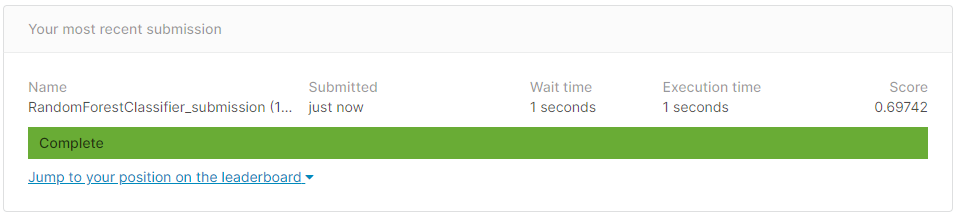